In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
train=pd.read_csv("../input/titanic/train.csv")
test=pd.read_csv("../input/titanic/test.csv")

# Train Data

In [2]:
#do the basic exploration things and find the number of null values
#train.describe()
#train.info()
#train.isnull().any()
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
#Dropping the columns which we dont need and that dont effect much
train.drop(columns=["PassengerId","Name","Ticket","Cabin"],axis=1,inplace=True)

<AxesSubplot:>

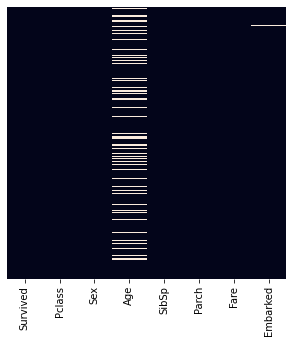

In [4]:
#plotting null values
plt.figure(figsize=(5,5))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

In [5]:
#dropping only the rows with null values in embarked column, can also use the below methods
#train[train['Embarked'].isnull()].index.tolist()
#train = train[train['Embarked'].notna()]

train.dropna(subset=['Embarked'],inplace=True)
train.Age.fillna(train.Age.mean(),inplace=True)

In [6]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# EDA

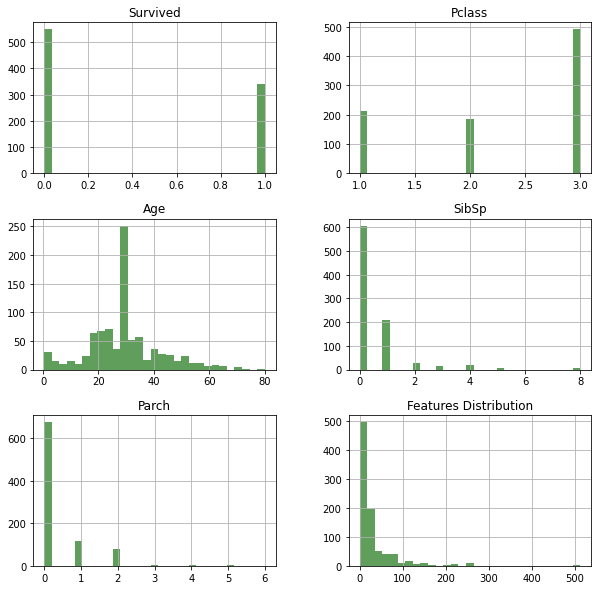

In [7]:
train.hist(figsize=(10,10),bins = 29, color="#107009AA")
plt.title("Features Distribution")
plt.show()

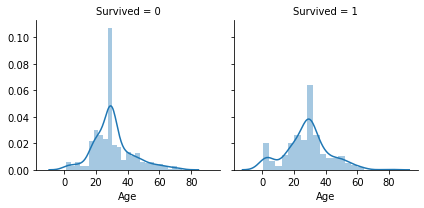

In [8]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

# feature analysis

In [9]:
print(train.Sex.unique())
print(train.Embarked.unique())

['male' 'female']
['S' 'C' 'Q']


In [10]:
train['Sex']=train['Sex'].map({'male':0,'female':1})
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2})

In [11]:
#oulier analysis using zscore
from scipy import stats
import numpy as np
a=np.mean(train.Fare)
print(a)
b=np.std(train.Fare)
print(b)

z = np.abs(stats.zscore(train))
print(z)
threshold = 3

32.09668087739032
49.669545099689564
[[0.78696114 0.82520863 0.73534203 ... 0.47432585 0.50023975 0.56968402]
 [1.27071078 1.57221121 1.35991138 ... 0.47432585 0.78894661 1.00313924]
 [1.27071078 0.82520863 1.35991138 ... 0.47432585 0.48664993 0.56968402]
 ...
 [0.78696114 0.82520863 1.35991138 ... 2.00611934 0.17408416 0.56968402]
 [1.27071078 1.57221121 0.73534203 ... 0.47432585 0.0422126  1.00313924]
 [0.78696114 0.82520863 0.73534203 ... 0.47432585 0.49017322 2.5759625 ]]


In [12]:
train = train[(z < 3).all(axis=1)]

In [13]:
#oulier analysis using inter quartile range IQR
from collections import Counter
def detect_outliers(df,n,features):
    outlier_indices = []
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [14]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

# Test data

In [15]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [16]:
test.drop(columns=["PassengerId","Name","Ticket","Cabin"],axis=1,inplace=True)

In [17]:
test['Sex']=test['Sex'].map({'male':0,'female':1})
test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2})

In [18]:
test.Fare.fillna(test.Fare.mean(),inplace=True)
test.Age.fillna(train.Age.mean(),inplace=True)

# Split and Model

In [19]:
xtrain=train.iloc[:,1:]
ytrain=train.iloc[:,0]
xtest=test

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier(booster = 'gbtree', gamma=5,learning_rate = 0.1, max_depth = 5, n_estimators = 100,colsample_bytree=1)
xgb.fit(xtrain, ytrain)
xgbpred=xgb.predict(xtest)

[09:11:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
prediction = pd.DataFrame(xgbpred)
submission= pd.read_csv('../input/titanic/gender_submission.csv')
submission['Survived'] = prediction
submission.to_csv('xgbpred21%.csv', index = False)